In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
import os
import boto3
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import csv
import numpy as np
from pathlib import Path

In [6]:
def maybe_pickle(data, filename, force=False):
    if os.path.exists(filename) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping pickling.' % filename)
    else:
        print('Pickling %s.' % filename)
        try:
            with open(filename, 'wb') as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', filename, ':', e)


def maybe_download(table, force=False):
    storage_file = table + ".pkl"
    if force or not os.path.exists(storage_file):
        data = data_retrieve(table)
        maybe_pickle(data, storage_file)
    return storage_file
        
def data_retrieve(table, page_size=100):
    """download data from table"""
    client = boto3.client('dynamodb')
    paginator = client.get_paginator('scan')

    counter = 0
    items = []
    for page in paginator.paginate(TableName=table, PaginationConfig={"PageSize": page_size}):
        items.extend(page["Items"])
        
        counter += 1
        if counter % 50 == 0:  # print debug every 50 pages
            print("items: {}. next page. {}. Count {}. ScannedCount: {}".format(len(items), counter, page["Count"], page["ScannedCount"]))


    return items
    

In [4]:
data_file = maybe_download("apthunt")
data = pickle.load(open(data_file, 'rb'))

In [5]:
print("wow")

wow


In [6]:
# To go from dynamo format to python
from boto3.dynamodb import types

deserializer = types.TypeDeserializer()
python_data = [{k: deserializer.deserialize(v) for k,v in d.items()} for d in data]

In [7]:
del data

In [8]:
df = pd.DataFrame(python_data)

In [9]:
del python_data

In [10]:
with open("df.pkl", 'wb') as f:
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)


## can restore from here

In [7]:
df = pickle.load(open("df.pkl", 'rb'))

In [8]:
df.head()

,parsed_postingtitletext,parsed_map_address,added,PostUrl,PostTitle,parsed_price,parsed_price_text,parsed_housing,PostContent,parsed_data_longitude,...,parsed_postingbody,parsed_page_head,parsed_thumbs,FeedTitle,parsed_titletextonly,intid,parsed_data_latitude,FeedUrl,PostPublished,parsed_notices
0,$3150 / 2br - 1300ft2 - Sunset Oaks Townhome- 1249 Crescent Terrace - Stocklmeir Elementary (sunnyvale) hide this posting unhide,1249 Crescent Terrace,1538706586266,https://sfbay.craigslist.org/sby/apa/d/sunset-oaks-townhome-1249/6709118961.html,simulated,3150,$3150,2br - 1300ft2,simulated,-122.026428,...,"Well designed and spacious 2 bedroom, 2 1/2 bath, 2-story townhome in the highly desired Sunset Oaks complex. Large rooms, laminate flooring on main level, carpeting in bedrooms on upper level, spacious closets, and an inside laundry area with full sized washer and dryer. Close proximity to Apple Park, Sunnyvale Community Center, Trader Joe's, Safeway, 24 Hour Super-Sport Fitness Center, Downtown Sunnyvale, great restaurants, parks, and more. Convenient access to freeways, Caltrain, and public transportation. Well maintained complex features lush greenery, sparkling pool, and clubhouse. Am...",None,"[https://images.craigslist.org/00Z0Z_5KZmIXxAcj_600x450.jpg, https://images.craigslist.org/00f0f_eqAOkWzKH9m_600x450.jpg, https://images.craigslist.org/00y0y_2WSGICUax4Y_600x450.jpg, https://images.craigslist.org/00C0C_4w5vpVhBoRh_600x450.jpg, https://images.craigslist.org/00I0I_8JjGKr4anFd_600x450.jpg, https://images.craigslist.org/00p0p_hc2jAs6AYJP_600x450.jpg, https://images.craigslist.org/00i0i_isU6lMVulur_600x450.jpg, https://images.craigslist.org/00k0k_fT9RSBrpZQp_600x450.jpg, https://images.craigslist.org/00m0m_9onzPH5Vru8_600x450.jpg, https://images.craigslist.org/00g0g_cnYTjPcfytH...",simulated,Sunset Oaks Townhome- 1249 Crescent Terrace - Stocklmeir Elementary,6aea5603583644368e76bac8293aa38a,37.353754,simulated,simulated,[do NOT contact me with unsolicited services or offers]
1,"$1769 / 2br - 875ft2 - ❄ Pittsburg Apartment Living, Gated Community, 24 Hour Fitness Gym (Pittsburg, CA) hide this posting unhide",2205 E Leland Rd,1539451812116,https://sfbay.craigslist.org/eby/apa/d/pittsburg-apartment-living/6720712945.html,simulated,1769,$1769,2br - 875ft2,simulated,-121.864673,...,"Diamond Hillside Apartment Homes offers spacious one and two-bedroom apartments for rent in Pittsburg, CA.\n\nThe apartments come with all-electric appliance packages that include microwaves and garbage disposals in the kitchens. The kitchens also include multi-cycle dishwashers for even more convenience. Wall-to-wall carpeting comes installed in the living areas, and stylish wood-inspired flooring comes outfitted in the kitchens and bathrooms. Additionally, many apartment homes within the community offer wood-burning fireplaces granite counters, and more.\n\nOnce you have settled into you...",None,"[https://images.craigslist.org/00c0c_505E4utDZFh_600x450.jpg, https://images.craigslist.org/00f0f_emM16TQdCvw_600x450.jpg, https://images.craigslist.org/00p0p_lA80gKwuKt1_600x450.jpg, https://images.craigslist.org/00W0W_XfXkafrgFM_600x450.jpg, https://images.craigslist.org/00S0S_jdFCqw6wbZj_600x450.jpg, https://images.craigslist.org/00M0M_ic9Z0FY8zkV_600x450.jpg, https://images.craigslist.org/00t0t_7qijSexvO1N_600x450.jpg, https://images.craigslist.org/00n0n_jdfZ7tcuO6e_600x450.jpg]",simulated,"❄ Pittsburg Apartment Living, Gated Community, 24 Hour Fitness Gym",0f490163255448ac973218ae45b7fa99,38.008321,simulated,simulated,[do NOT contact me with unsolicited services or offers]
2,$3000 / 2br - 1800ft2 - 2 Bedroom 1 Bath 1 Car Garage House (excelsior / outer mission) hide this posting unhide,375 Pope Street,1538947757137,https://sfbay.craigslist.org/sfc/apa/d/2-bedroom-1-bath-1-car-garage/6712471985.html,simulated,3000,$3000,2br - 1800ft2,simulated,-122.439706,...,"clean 2 Bedroom 1 full bathroom 1 car garage. perfect for small family or working professiona

In [9]:
# small cleanup of "simulated"
del df["FeedTitle"]
del df["FeedUrl"]
del df["PostContent"]
del df["PostPublished"]
del df["PostTitle"]
# delete parsed_notices. looks like it is the same
del df["parsed_notices"]
# no need for price text
del df["parsed_price_text"]

In [10]:
df.columns

Index(['parsed_postingtitletext', 'parsed_map_address', 'added', 'PostUrl',
       'parsed_price', 'parsed_housing', 'parsed_data_longitude',
       'parsed_attrs', 'parsed_district', 'parsed_map_link',
       'parsed_postingbody', 'parsed_page_head', 'parsed_thumbs',
       'parsed_titletextonly', 'intid', 'parsed_data_latitude'],
      dtype='object')

In [11]:
def clean_parsed_args(args):
    if not isinstance(args, list):
        return []
    clean = []
    for p in args:
        # remove days
        if p.startswith("friday") or p.startswith("monday") or p.startswith("saturday") or p.startswith("sunday") or p.startswith("thursday") or p.startswith("tuesday") or p.startswith("wednesday"):
            continue
        # remove br/ba
        if "BR / " in p: continue
        # remove ft2
        if p.endswith("ft2"): continue

        # remove application fee
        if p.startswith("application fee"): continue
        
        # remove broker fee
        if p.startswith("broker fee"): continue
        
        # remove available
        if p.startswith("available"): continue
        
        # remove listed by
        if p.startswith("listed by"): continue
        clean.append(p)
    return clean
        

In [12]:
df['parsed_attrs'] = df['parsed_attrs'].map(clean_parsed_args)
# one_hot = pd.get_dummies(df['parsed_attrs'])

In [13]:
df['parsed_attrs']

0                                                                 [townhouse, w/d in unit, no smoking, detached garage]
1                                                                                                           [apartment]
2                                                                 [house, laundry in bldg, no smoking, attached garage]
3                                                                                 [house, w/d hookups, detached garage]
4                               [cats are OK - purrr, dogs are OK - wooof, apartment, w/d in unit, no smoking, carport]
                                                              ...                                                      
843726                                                       [cats are OK - purrr, apartment, laundry on site, carport]
843727                                                            [townhouse, w/d in unit, no smoking, detached garage]
843728                                  

In [14]:
df.head()

,parsed_postingtitletext,parsed_map_address,added,PostUrl,parsed_price,parsed_housing,parsed_data_longitude,parsed_attrs,parsed_district,parsed_map_link,parsed_postingbody,parsed_page_head,parsed_thumbs,parsed_titletextonly,intid,parsed_data_latitude
0,$3150 / 2br - 1300ft2 - Sunset Oaks Townhome- 1249 Crescent Terrace - Stocklmeir Elementary (sunnyvale) hide this posting unhide,1249 Crescent Terrace,1538706586266,https://sfbay.craigslist.org/sby/apa/d/sunset-oaks-townhome-1249/6709118961.html,3150,2br - 1300ft2,-122.026428,"[townhouse, w/d in unit, no smoking, detached garage]",sunnyvale,https://maps.google.com/?q=loc%3A+%31%32%34%39+Crescent+Terrace+Sunnyvale+CA+US,"Well designed and spacious 2 bedroom, 2 1/2 bath, 2-story townhome in the highly desired Sunset Oaks complex. Large rooms, laminate flooring on main level, carpeting in bedrooms on upper level, spacious closets, and an inside laundry area with full sized washer and dryer. Close proximity to Apple Park, Sunnyvale Community Center, Trader Joe's, Safeway, 24 Hour Super-Sport Fitness Center, Downtown Sunnyvale, great restaurants, parks, and more. Convenient access to freeways, Caltrain, and public transportation. Well maintained complex features lush greenery, sparkling pool, and clubhouse. Am...",None,"[https://images.craigslist.org/00Z0Z_5KZmIXxAcj_600x450.jpg, https://images.craigslist.org/00f0f_eqAOkWzKH9m_600x450.jpg, https://images.craigslist.org/00y0y_2WSGICUax4Y_600x450.jpg, https://images.craigslist.org/00C0C_4w5vpVhBoRh_600x450.jpg, https://images.craigslist.org/00I0I_8JjGKr4anFd_600x450.jpg, https://images.craigslist.org/00p0p_hc2jAs6AYJP_600x450.jpg, https://images.craigslist.org/00i0i_isU6lMVulur_600x450.jpg, https://images.craigslist.org/00k0k_fT9RSBrpZQp_600x450.jpg, https://images.craigslist.org/00m0m_9onzPH5Vru8_600x450.jpg, https://images.craigslist.org/00g0g_cnYTjPcfytH...",Sunset Oaks Townhome- 1249 Crescent Terrace - Stocklmeir Elementary,6aea5603583644368e76bac8293aa38a,37.353754
1,"$1769 / 2br - 875ft2 - ❄ Pittsburg Apartment Living, Gated Community, 24 Hour Fitness Gym (Pittsburg, CA) hide this posting unhide",2205 E Leland Rd,1539451812116,https://sfbay.craigslist.org/eby/apa/d/pittsburg-apartment-living/6720712945.html,1769,2br - 875ft2,-121.864673,[apartment],"Pittsburg, CA",https://maps.google.com/?q=loc%3A+%32%32%30%35+E+Leland+Rd+Pittsburg+CA+US,"Diamond Hillside Apartment Homes offers spacious one and two-bedroom apartments for rent in Pittsburg, CA.\n\nThe apartments come with all-electric appliance packages that include microwaves and garbage disposals in the kitchens. The kitchens also include multi-cycle dishwashers for even more convenience. Wall-to-wall carpeting comes installed in the living areas, and stylish wood-inspired flooring comes outfitted in the kitchens and bathrooms. Additionally, many apartment homes within the community offer wood-burning fireplaces granite counters, and more.\n\nOnce you have settled into you...",None,"[https://images.craigslist.org/00c0c_505E4utDZFh_600x450.jpg, https://images.craigslist.org/00f0f_emM16TQdCvw_600x450.jpg, https://images.craigslist.org/00p0p_lA80gKwuKt1_600x450.jpg, https://images.craigslist.org/00W0W_XfXkafrgFM_600x450.jpg, https://images.craigslist.org/00S0S_jdFCqw6wbZj_600x450.jpg, https://images.craigslist.org/00M0M_ic9Z0FY8zkV_600x450.jpg, https://images.craigslist.org/00t0t_7qijSexvO1N_600x450.jpg, https://images.craigslist.org/00n0n_jdfZ7tcuO6e_600x450.jpg]","❄ Pittsburg Apartment Living, Gated Community, 24 Hour Fitness Gym",0f490163255448ac973218ae45b7fa99,38.008321
2,$3000 / 2br - 1800ft2 - 2 Bedroom 1 Bath 1 Car Garage House (excelsior / outer mission) hide this posting unhide,375 Pope Street,1538947757137,https://sfbay.craigslist.org/sfc/apa/d/2-bedroom-1-bath-1-car-garage/6712471985.html,3000,2br - 1800ft2,-122.439706,"[house, laundry in bldg, no smoking, attached garage]",excelsior / outer mission,https://maps.google.com/?q=loc%3A+%33%37%35+Pope+Street+San+Francisco+C

In [15]:
df.shape

(843731, 16)

In [16]:
def get_type(attrs):
    if not isinstance(attrs, list):
        return None
    types = set([
        "apartment", 
        "townhouse", 
        "loft", 
        "land", 
        "house", 
        "duplex", 
        "flat", 
        "condo", 
        "cottage/cabin"
    ])
    return ",".join(sorted(types & set(attrs)))

In [17]:
def prepare_data(df):
    new  = pd.DataFrame()
    new["PostUrl"] = df["PostUrl"]
    new["latitude"] = df["parsed_data_latitude"]
    new["longitude"] = df["parsed_data_longitude"]
    new["district"] = df["parsed_district"].map(lambda s: s.strip("()") if isinstance(s, str) else s)
    new["address"] = df["parsed_map_address"].map(lambda x: x if x != "(google map)" else None)
    new["housing"] = df["parsed_housing"]
    
    new["price"] = df["parsed_price"].map(lambda x: float(x) if x else x)
    
    # to numerical values
    new['price'] = pd.to_numeric(new['price'])
    new['longitude'] = pd.to_numeric(new['longitude'])
    new['latitude'] = pd.to_numeric(new['latitude'])
    
    new['bedrooms'] = new['housing'].str.extract('(\d+)br\s.*', expand=True)
    new['bedrooms'] = pd.to_numeric(new['bedrooms'])
    
    new['area'] = new['housing'].str.extract('(\d+)ft2', expand=True)
    new['area'] = pd.to_numeric(new['area'])
    
    new['type'] = df["parsed_attrs"].map(get_type)
    new['catsok'] = df["parsed_attrs"].map(lambda x: "cats are OK - purrr" in x)
    new['dogsok'] = df["parsed_attrs"].map(lambda x: "dogs are OK - wooof" in x)
    new['garagea'] = df["parsed_attrs"].map(lambda x: "attached garage" in x)
    new['garaged'] = df["parsed_attrs"].map(lambda x: "detached garage" in x)
    new['furnished'] = df["parsed_attrs"].map(lambda x: "furnished" in x)
    
    new['laundryb'] = df["parsed_attrs"].map(lambda x: "laundry in bldg" in x)
    new['laundrys'] = df["parsed_attrs"].map(lambda x: "laundry on site" in x)
    
    new['wd'] = df["parsed_attrs"].map(lambda x: "w/d in unit" in x)
    new['nthumbs'] = df["parsed_thumbs"].apply(lambda x: len(x) if isinstance(x, list) else 0)

    return new

In [18]:
short = prepare_data(df)

In [19]:
short

,PostUrl,latitude,longitude,district,address,housing,price,bedrooms,area,type,catsok,dogsok,garagea,garaged,furnished,laundryb,laundrys,wd,nthumbs
0,https://sfbay.craigslist.org/sby/apa/d/sunset-oaks-townhome-1249/6709118961.html,37.353754,-122.026428,sunnyvale,1249 Crescent Terrace,2br - 1300ft2,3150.0,2.0,1300.0,townhouse,False,False,False,True,False,False,False,True,18
1,https://sfbay.craigslist.org/eby/apa/d/pittsburg-apartment-living/6720712945.html,38.008321,-121.864673,"Pittsburg, CA",2205 E Leland Rd,2br - 875ft2,1769.0,2.0,875.0,apartment,False,False,False,False,False,False,False,False,8
2,https://sfbay.craigslist.org/sfc/apa/d/2-bedroom-1-bath-1-car-garage/6712471985.html,37.710526,-122.439706,excelsior / outer mission,375 Pope Street,2br - 1800ft2,3000.0,2.0,1800.0,house,False,False,True,False,False,True,False,False,5
3,https://sfbay.craigslist.org/eby/apa/d/fairfield-updated-1200-sq-ft-3-bed-15/7097278416.html,38.274790,-122.019156,fairfield / vacaville,2436 Baltic Dr,3br - 1200ft2,2150.0,3.0,1200.0,house,False,False,False,True,False,False,False,False,10
4,https://sfbay.craigslist.org/eby/apa/d/hayward-fully-renovated-1bed-1bath-in/7112941389.html,37.671644,-122.076737,hayward / castro valley,1182 E Street near 2nd,1br - 726ft2,2150.0,1.0,726.0,apartment,True,True,False,False,False,False,False,True,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843726,https://sfbay.craigslist.org/sby/apa/d/ideal-1br-1ba-apt-prime-santa/6709995677.html,37.337841,-121.978369,santa clara,2865 Homestead Rd,1br - 750ft2,2195.0,1.0,750.0,apartment,True,False,False,False,False,False,True,False,12
843727,https://sfbay.craigslist.org/eby/apa/d/fremont-2-bed-15-bath-corner-unit/7071943857.html,37.552033,-121.996875,fremont / union city / newark,4095 EGGERS DR,2br - 1000ft2,2800.0,2.0,1000.0,townhouse,False,False,False,True,False,False,False,True,8
843728,https://sfbay.craigslist.org/eby/apa/d/your-new-home-awaits-in/6608718676.html,NaN,NaN,fairfield / vacaville,NaN,/ 2br - 918ft2 -,1965.0,2.0,918.0,,False,False,False,False,False,False,False,False,18
843729,https://sfbay.craigslist.org/sfc/apa/d/san-francisco-furnished-modern-rincon/7087963613.html,37.787295,-122.392719,Rincon Hill,"340 Fremont St, San Francisco, CA 94105, USA",1br - 708ft2,4890.0,1.0,708.0,apartment,True,True,False,False,True,False,False,True,22


In [20]:
short.shape

(843731, 19)

In [21]:
short.dropna(subset=["price"], inplace=True)
short.shape

(838998, 19)

In [22]:
short["price"].describe()

count    8.389980e+05
mean     3.575694e+14
std      3.275222e+17
min      0.000000e+00
25%      2.095000e+03
50%      2.656000e+03
75%      3.495000e+03
max      3.000000e+20
Name: price, dtype: float64

In [23]:
# change all prices more than 9k to to 9 k
short.loc[short['price'] > 9000, "price"] = 9000

In [24]:
short["price"].describe()

count    838998.000000
mean       2934.234154
std        1347.415174
min           0.000000
25%        2095.000000
50%        2656.000000
75%        3495.000000
max        9000.000000
Name: price, dtype: float64

In [25]:
short.shape

(838998, 19)

In [26]:
short.drop_duplicates(inplace=True)
short.shape

(578270, 19)

In [27]:
short['price_bucket'] = short['price'].apply(lambda x: f"{x//500:02.0f}x500")

In [28]:
short.head()

,PostUrl,latitude,longitude,district,address,housing,price,bedrooms,area,type,catsok,dogsok,garagea,garaged,furnished,laundryb,laundrys,wd,nthumbs,price_bucket
0,https://sfbay.craigslist.org/sby/apa/d/sunset-oaks-townhome-1249/6709118961.html,37.353754,-122.026428,sunnyvale,1249 Crescent Terrace,2br - 1300ft2,3150.0,2.0,1300.0,townhouse,False,False,False,True,False,False,False,True,18,06x500
1,https://sfbay.craigslist.org/eby/apa/d/pittsburg-apartment-living/6720712945.html,38.008321,-121.864673,"Pittsburg, CA",2205 E Leland Rd,2br - 875ft2,1769.0,2.0,875.0,apartment,False,False,False,False,False,False,False,False,8,03x500
2,https://sfbay.craigslist.org/sfc/apa/d/2-bedroom-1-bath-1-car-garage/6712471985.html,37.710526,-122.439706,excelsior / outer mission,375 Pope Street,2br - 1800ft2,3000.0,2.0,1800.0,house,False,False,True,False,False,True,False,False,5,06x500
3,https://sfbay.craigslist.org/eby/apa/d/fairfield-updated-1200-sq-ft-3-bed-15/7097278416.html,38.274790,-122.019156,fairfield / vacaville,2436 Baltic Dr,3br - 1200ft2,2150.0,3.0,1200.0,house,False,False,False,True,False,False,False,False,10,04x500
4,https://sfbay.craigslist.org/eby/apa/d/hayward-fully-renovated-1bed-1bath-in/7112941389.html,37.671644,-122.076737,hayward / castro valley,1182 E Street near 2nd,1br - 726ft2,2150.0,1.0,726.0,apartment,True,True,False,False,False,False,False,True,8,04x500


In [29]:
short["price_bucket"].describe()

count     578270
unique        19
top       04x500
freq      118793
Name: price_bucket, dtype: object

In [92]:
export_path = Path("./apthuntdata")
export_path.mkdir(exist_ok=True)
short.to_csv(export_path/"data.csv", index=False) 

In [31]:
short["price"].describe()

count    578270.000000
mean       2942.898278
std        1321.872762
min           0.000000
25%        2100.000000
50%        2695.000000
75%        3500.000000
max        9000.000000
Name: price, dtype: float64

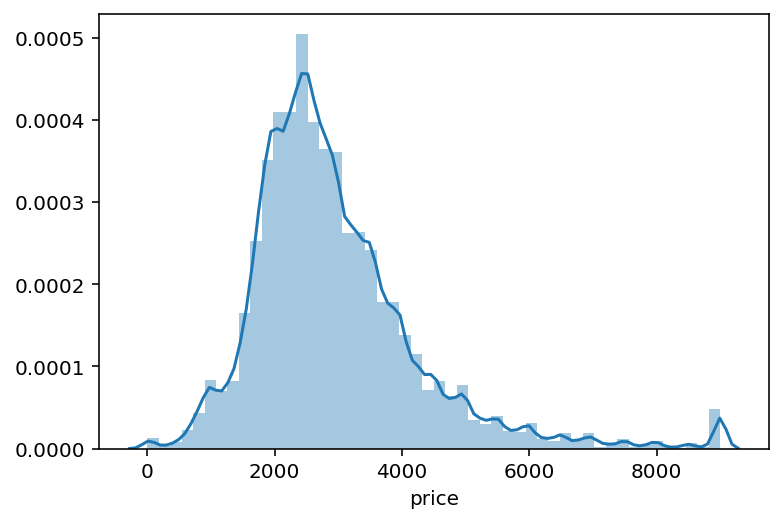

In [32]:
sns.distplot(short.loc[:, "price"])

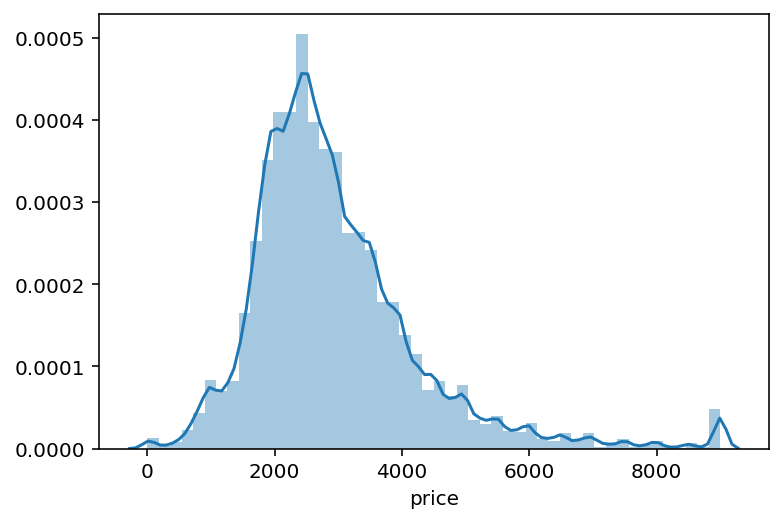

In [33]:
sns.distplot(short.loc[short["price"] < 20000, "price"])

In [34]:
short[short.price > 15000].describe()

,latitude,longitude,price,bedrooms,area,nthumbs
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
1094/578376

0.0018915031052464141

In [36]:
from fastai2.tabular.all import *

In [37]:
def mean_abs_diff(inp, target):
    return (inp - target).abs().mean()
def min_abs_diff(inp, target):
    return (inp - target).abs().min()
def max_abs_diff(inp, target):
    return (inp - target).abs().max()

In [38]:
learn_inf = load_learner('cltab.pkl')

In [45]:
short.iloc[0]

PostUrl         https://sfbay.craigslist.org/sby/apa/d/sunset-oaks-townhome-1249/6709118961.html
latitude                                                                                 37.3538
longitude                                                                               -122.026
district                                                                               sunnyvale
address                                                                    1249 Crescent Terrace
housing                                                                            2br - 1300ft2
price                                                                                       3150
bedrooms                                                                                       2
area                                                                                        1300
type                                                                                   townhouse
catsok                        

In [70]:
tp = pd.read_csv("apthuntdata/data.csv").loc[0]

In [71]:
del tp["PostUrl"]
del tp["address"]
del tp["price"]
del tp["price_bucket"]

In [72]:
tp

latitude           37.3538
longitude         -122.026
district         sunnyvale
housing      2br - 1300ft2
bedrooms                 2
area                  1300
type             townhouse
catsok               False
dogsok               False
garagea              False
garaged               True
furnished            False
laundryb             False
laundrys             False
wd                    True
nthumbs                 18
Name: 0, dtype: object

In [91]:
prediction = learn_inf.predict(tp)
i = 0
for p in prediction:
    print("-" * 11)
    print(i)
    i += 1
    print(p)
    print(type(p))

-----------
0
   housing  district  bedrooms  type  catsok  dogsok  garagea  garaged  \
0   4928.0    3974.0       2.0   9.0     1.0     1.0      1.0      2.0   

   furnished  laundryb  laundrys   wd  nthumbs  latitude_na  longitude_na  \
0        1.0       1.0       1.0  2.0     19.0          1.0           1.0   

   area_na  latitude  longitude      area        price  
0      1.0  -0.75236   0.282444  0.014817  3281.245605  
<class 'fastai2.tabular.core.TabularPandas'>
-----------
1
tensor([3281.2456])
<class 'torch.Tensor'>
-----------
2
tensor([3281.2456])
<class 'torch.Tensor'>


In [93]:
pd.read_csv("apthuntdata/data.csv").loc[0]

PostUrl         https://sfbay.craigslist.org/sby/apa/d/sunset-oaks-townhome-1249/6709118961.html
latitude                                                                                 37.3538
longitude                                                                               -122.026
district                                                                               sunnyvale
address                                                                    1249 Crescent Terrace
housing                                                                            2br - 1300ft2
price                                                                                       3150
bedrooms                                                                                       2
area                                                                                        1300
type                                                                                   townhouse
catsok                        

In [98]:
topred = pd.read_csv("apthuntdata/data.csv")
del topred["PostUrl"]
del topred["address"]
del topred["price"]
del topred["price_bucket"]

In [102]:
learn_inf.predict(topred)

KeyError: "None of [Index(['latitude', 'longitude', 'area'], dtype='object')] are in the [columns]"

In [101]:
topred.loc[0:1]

,latitude,longitude,district,housing,bedrooms,area,type,catsok,dogsok,garagea,garaged,furnished,laundryb,laundrys,wd,nthumbs
0,37.353754,-122.026428,sunnyvale,2br - 1300ft2,2.0,1300.0,townhouse,False,False,False,True,False,False,False,True,18
1,38.008321,-121.864673,"Pittsburg, CA",2br - 875ft2,2.0,875.0,apartment,False,False,False,False,False,False,False,False,8


In [109]:
topred.apply(lambda x: f"{x['latitude']} + {x['district']}", axis=1)

0                37.353753999999995 + sunnyvale
1                     38.008321 + Pittsburg, CA
2         37.710526 + excelsior / outer mission
3              38.27479 + fairfield / vacaville
4           37.671644 + hayward / castro valley
                          ...                  
578265                 37.486829 + redwood city
578266                  37.337841 + santa clara
578267              nan + fairfield / vacaville
578268                  37.787295 + Rincon Hill
578269        37.3108 + ingleside / SFSU / CCSF
Length: 578270, dtype: object

In [ ]:
topred["price"] = topred.apply(learn_inf.predict, axis=1)